References:


1.   https://www.kaggle.com/mdteach/image-captioning-with-attention-pytorch
2.   https://www.kaggle.com/dipanjandas96/image-caption-resnet-transformerdecoder-pytorch
3.   https://xiangyutang2.github.io/image-captioning/
4.   https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html
5.   https://github.com/deepsemantic/image_captioning
6.   https://github.com/dksifoua/Neural-Image-Caption-Generator


* https://www.kaggle.com/rishabhchaurasia7/image-captioning-on-flickr8k-dataset



* https://www.kaggle.com/mdteach/image-captioning-with-attention-pytorch

>> * https://pytorch.org/tutorials/beginner/transformer_tutorial.html


# Collecting and Downloading Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Dataset/Flickr.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

# Importing necessary libraries

In [ ]:
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import string
import time
import re

import pickle
from pickle import load,dump

import tensorflow as tf

from nltk.translate.bleu_score import sentence_bleu
from nltk import FreqDist

from keras.preprocessing.text import Tokenizer

import torchvision
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence

import torchvision
import torchvision.models as models
from torchtext.data.metrics import bleu_score

from PIL import Image
import multiprocessing

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.5.0


In [ ]:
no_of_cpu = multiprocessing.cpu_count()
print('Number of CPUs: '+str(no_of_cpu))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Number of CPUs: 2
cuda


# Exploring Data

In [ ]:
data = pd.read_csv('/content/captions.txt',delimiter=',')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
data.shape

(40455, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


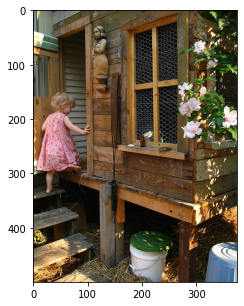

0    A child in a pink dress is climbing up a set o...
1                A girl going into a wooden building .
2     A little girl climbing into a wooden playhouse .
3    A little girl climbing the stairs to her playh...
4    A little girl in a pink dress going into a woo...
Name: caption, dtype: object

In [ ]:
ii=0
fig = plt.figure(figsize =(5,5))
img=cv2.imread('Images/'+data.image[ii*5])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()
data.caption[ii*5:(ii+1)*5]

## Data Preprocessing


*   Change captions to lower case
*   Remove punctuation marks
*   STARTSEQ and ENDSEQ is added to indicate the start and end of the caption
*   Words with frequency less than 10 were removed



In [ ]:
def clean(text):
  text = re.sub(r'[^\w\s]', '',text.lower())  #removes punctuations
  text = '<STARTSEQ> '+text.strip()+' <ENDSEQ>';
  return text

In [ ]:
def img_caption_dict(data):
  desc = dict()                      #creates a dictionary of the form {image id:list of captions associated with this id}
  for _,row in data.iterrows():
    image_id,image_desc = row['image'],row['caption']
    image_id = image_id.split(".")[0]
    image_desc = clean(image_desc)
    if image_id in desc:
      desc[image_id].append(image_desc)
    else:
      desc[image_id] = list()
      desc[image_id].append(image_desc)
  return desc

In [ ]:
def make_vocabulary(desc):                       #makes a vocabulary of the words in the captions
  corpus = ""
  for i in desc.values():
    for j in i:
      corpus += " "+j
  total_words = corpus.split()
  vocabulary = set(total_words)
  freq = FreqDist(total_words)
  for word in list(vocabulary):
    if(freq[word]<10):                          #remove words with frequency less than 10
      vocabulary.remove(word)                 
  vocab_size = len(vocabulary)+1
  return vocabulary, vocab_size



In [ ]:
def train_test_split(desc,train_size=0.8,shuffle=False):
  all_images = list(desc.keys())
  if shuffle:
    np.random.shuffle(all_images)
  train_size = int(len(desc) * train_size)

  train_desc = {
        img_name: desc[img_name] for img_name in all_images[:train_size]
  }
  test_desc = {
        img_name: desc[img_name] for img_name in all_images[train_size:]
  }
  return train_desc,test_desc

In [ ]:
def get_word_embeddings(train_desc,vocabulary,VOCAB_SIZE):
  text_data=[]
  for word in train_desc.values():
    for i in word:
      text_data.append(i)
  token = Tokenizer(num_words=VOCAB_SIZE)
  token.fit_on_texts(text_data)
  ix_to_word = token.index_word
  for k in list(ix_to_word):
      if k>=VOCAB_SIZE:
          ix_to_word.pop(k, None)
  word_to_ix = dict()
  for k,v in ix_to_word.items():
      word_to_ix[v] = k

  embeddings = {}

  with open("/content/gdrive/MyDrive/Dataset/glove.6B.200d.txt", 'r', encoding='utf-8') as f:
      for line in f:
          values = line.split()
          word = values[0]
          coeffs = np.array(values[1:], dtype="float32")
        
          embeddings[word] = coeffs

  EMBEDDING_SIZE = 200
  embedding_matrix = np.zeros(((VOCAB_SIZE),EMBEDDING_SIZE))

  for word, i in word_to_ix.items():
    emb_vec = embeddings.get(word)
    if emb_vec is not None:
      embedding_matrix[i] = emb_vec

  return embedding_matrix  

['<STARTSEQ> a man in a pink shirt climbs a rock face <ENDSEQ>', '<STARTSEQ> a man is rock climbing high in the air <ENDSEQ>', '<STARTSEQ> a person in a red shirt climbing up a rock face covered in assist handles <ENDSEQ>', '<STARTSEQ> a rock climber in a red shirt <ENDSEQ>', '<STARTSEQ> a rock climber practices on a rock climbing wall <ENDSEQ>']


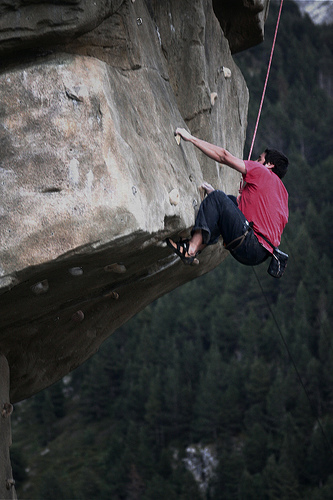

In [ ]:
img = tf.keras.preprocessing.image.load_img('Images/997722733_0cb5439472.jpg')
desc = img_caption_dict(data)

print(desc['997722733_0cb5439472'])
img


In [ ]:
len(desc)

8091

In [ ]:
train_desc,test_desc = train_test_split(desc)
vocabulary,VOCAB_SIZE=make_vocabulary(train_desc)
embedding_matrix = get_word_embeddings(train_desc,vocabulary,VOCAB_SIZE)
print(embedding_matrix.shape)
print(len(train_desc))


6472


In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.24168999, -0.34534001, -0.22307   , ...,  0.27801001,
        -0.10171   , -0.071521  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.45975   , -0.091944  , -0.51722002, ..., -0.33171999,
         0.076498  ,  0.15044001],
       [-0.48324001, -0.60266   , -0.55751002, ...,  0.22618   ,
        -0.083401  , -0.52244997],
       [ 0.18769   ,  0.77225   , -0.50244999, ...,  0.25538   ,
         0.048633  ,  0.77714998]])

In [ ]:
def center_crop(fn):
  img=Image.open(fn)
  w,h=img.size
  s=min(w,h)
  y=(h-s)//2
  x=(w-s)//2
  img=img.crop((x,y,s,s))
  plt.imshow(np.asarray(img))
  return img

### **Data Augmentation**
> * Used when we don't have sufficient data for training. 
> * Image augmentation is a technique of altering the existing data to create some more data for the model training process. In other words, it is the process of artificially expanding the available dataset for training a deep learning model.
> * Different Image Augmentation Techniques
>> *  Image Rotation
>> *  Image Flipping
>> *  Image Noising
>> *  Image Blurring

In [ ]:
def resize_image(desc):
  images_dict = dict()
  TARGET = (299,299)
  for key in desc:
    img = cv2.imread('/content/Images/'+key+'.jpg')
    resized_img = cv2.resize(img, dsize = (299,299), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite('/content/Images/'+key+'_resize'+'.jpg',resized_img)
    images_dict[key] = resized_img
  return images_dict
images_dict = resize_image(desc)

In [ ]:
import random
def image_flip_augment_dict(images_dict):
  image_flip_dict = dict()
  for key in images_dict:
    flip_image = cv2.flip(images_dict[key],random.randint(-1, 1))
    cv2.imwrite('/content/Images/'+key+'_flip'+'.jpg',flip_image)
    #image_flip_dict[key] = flip_image
  return image_flip_dict
image_flip_dict = image_flip_augment_dict(images_dict)

In [ ]:

def image_rotate_augment_dict(images_dict):
  image_rotate_dict = dict()
  for key in images_dict:
    rows, columns = images_dict[key].shape[:2]
    random_angle = random.randint(-180,180)
    rotate_matrix = cv2.getRotationMatrix2D((columns/2,rows/2), random_angle,1)
    rotate_image = cv2.warpAffine(images_dict[key], rotate_matrix, (columns, rows))
    cv2.imwrite('/content/Images/'+key+'_rotate'+'.jpg',rotate_image)
    #image_rotate_dict[key] = rotate_image
  return image_rotate_dict
image_rotate_dict = image_rotate_augment_dict(images_dict)

In [ ]:
def image_noise_augment_dict(images_dict):
  image_noise_dict = dict()
  for key in images_dict:
    rows, cols = images_dict[key].shape[:2]
    aug_img = cv2.cvtColor(images_dict[key], cv2.COLOR_RGB2HSV) # transform to HSV color space .
    h, s, v = cv2.split(aug_img) # split each channel in order to add seperate range of values to each channel.
    h += np.random.randint(0, 100,size=(rows, cols), dtype=np.uint8 )
    s += np.random.randint(0, 20,size=(rows, cols), dtype=np.uint8 )
    v += np.random.randint(0, 10,size=(rows, cols) , dtype=np.uint8 )
    aug_img = cv2.merge([h,s,v ])
    noise_image = cv2.cvtColor(aug_img, cv2.COLOR_HSV2RGB)
    cv2.imwrite('/content/Images/'+key+'_noise'+'.jpg',noise_image)
    #image_noise_dict[key] = noise_image
  return image_noise_dict
image_noise_dict = image_noise_augment_dict(images_dict)

In [ ]:
def image_blur_augment_dict(images_dict):
  image_blur_dict = dict()
  for key in images_dict:
    blur_value = random.randint(5,15)
    blur_image = cv2.blur(images_dict[key],(blur_value,blur_value))
    cv2.imwrite('/content/Images/'+key+'_blur'+'.jpg',blur_image)
    #image_blur_dict[key] = blur_image
  return image_blur_dict
image_blur_dict = image_blur_augment_dict(images_dict)

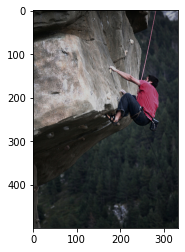

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread('Images/997722733_0cb5439472.jpg'),cv2.COLOR_BGR2RGB))

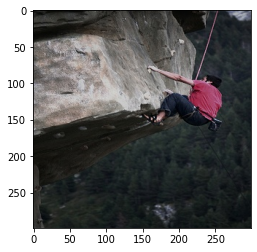

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread('/content/Images/997722733_0cb5439472_resize.jpg'),cv2.COLOR_BGR2RGB))

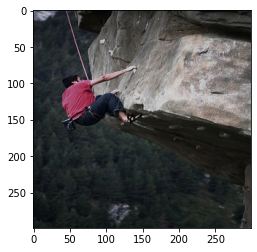

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread('/content/Images/997722733_0cb5439472_flip.jpg'),cv2.COLOR_BGR2RGB))

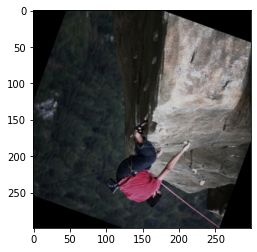

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread('/content/Images/997722733_0cb5439472_rotate.jpg'),cv2.COLOR_BGR2RGB))

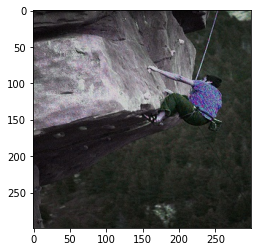

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread('/content/Images/997722733_0cb5439472_noise.jpg'),cv2.COLOR_BGR2RGB))

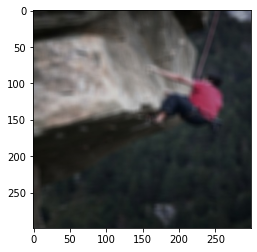

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread('/content/Images/997722733_0cb5439472_blur.jpg'),cv2.COLOR_BGR2RGB))

In [ ]:
import os
print(len(os.listdir('/content/Images')))

48546


In [ ]:
cap_dict=dict()
for key in desc:
  cap_dict[key]=desc[key]
  cap_dict[key+'_resize']=desc[key]
  cap_dict[key+'_flip']=desc[key]
  cap_dict[key+'_rotate']=desc[key]
  cap_dict[key+'_noise']=desc[key]
  cap_dict[key+'_blur']=desc[key]
len(cap_dict)

48546

['<STARTSEQ> a child in a pink dress is climbing up a set of stairs in an entry way <ENDSEQ>', '<STARTSEQ> a girl going into a wooden building <ENDSEQ>', '<STARTSEQ> a little girl climbing into a wooden playhouse <ENDSEQ>', '<STARTSEQ> a little girl climbing the stairs to her playhouse <ENDSEQ>', '<STARTSEQ> a little girl in a pink dress going into a wooden cabin <ENDSEQ>']


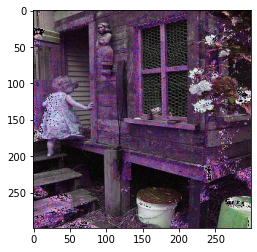

In [ ]:
ii1='1000268201_693b08cb0e_noise'
print(cap_dict[ii1])
plt.imshow(cv2.cvtColor(cv2.imread('Images/'+ii1+'.jpg'),cv2.COLOR_BGR2RGB))

#Model
We will be doing transfer learning i.e taking a pre-trained network and retraining it on new data for a new task. \\

### **Encoder Network**


For the encoder part we can one of the following pre trained *models*
*   VGG
*   ResNet
*   Inception v3
*   Xception, etc \\
All these modelsdiffer in complexity and architecture





##### **ResNet**

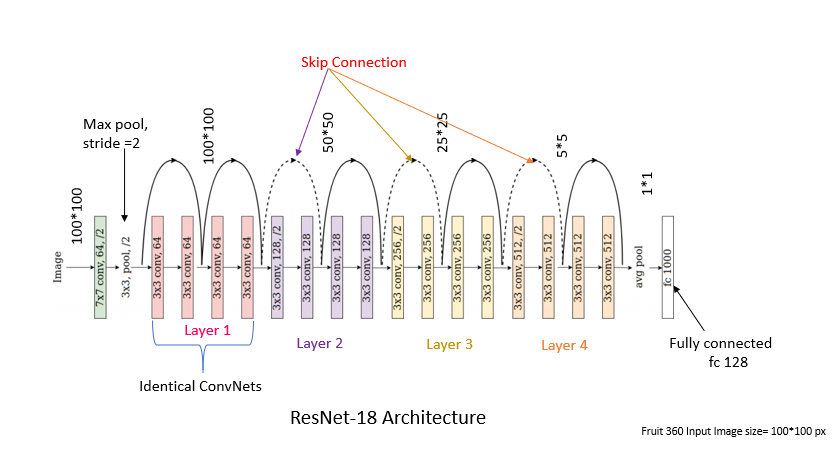

In [ ]:
from collections import Counter 

def create_train_test_text_seq(desc):
  mx=0
  for lst in desc.values():
    for caption in lst:
      mx = max(len(caption.split()),mx)

  df = pd.DataFrame(columns = ['image_id', 'txt_seq'])
  col1=list()
  col2=list()
  for key,lst in desc.items():
    for caption in lst:
      l = len(caption.split())
      caption_lst = caption.split() + ['<pad>']*(mx-l)
      col1.append(key)
      col2.append(caption_lst)
 
  df['image_id']=col1
  df['txt_seq']=col2

  word_list = df['txt_seq'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
  word_dict = Counter(word_list)
  word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)
  index_to_word = {index: word for index, word in enumerate(word_dict)}
  word_to_index = {word: index for index, word in enumerate(word_dict)}
  df['seq']=df['txt_seq'].apply(lambda caption : [word_to_index[word] for word in caption])
  train = df.iloc[:int(0.9*len(df))]
  test = df.iloc[int(0.9*len(df)):]
 
  return train,test

(6472, 1619)

In [ ]:
train,test = create_train_test_text_seq(desc)

In [ ]:
unq_train_imgs = train[['image_id']].drop_duplicates()
unq_test_imgs = test[['image_id']].drop_duplicates()

In [ ]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self,idx):

        image_name = self.data.iloc[idx]['image_id']
        img_loc = '/content/Images/'+str(image_name)+'.jpg'

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [ ]:
def get_vector_embeddings(transformed_img):
    
    transformed_img = Variable(transformed_img)
    embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
      embedding.copy_(o.data)
    
    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(transformed_img)
    
    h.remove()
    return embedding

In [ ]:
train_resnet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_resnet, batch_size = 1, shuffle=False)
test_resnet = extractImageFeatureResNetDataSet(unq_test_imgs)
test_ImageDataloader_ResNet = DataLoader(test_resnet, batch_size = 1, shuffle=False)    

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [ ]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)
resNet18Layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [ ]:
train_extracted_resnet = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    emb = get_vector_embeddings(t_img) 
    train_extracted_resnet[image_name[0]] = emb



In [ ]:
len(train_extracted_resnet)

6472

In [ ]:
test_extracted_resnet = {}
for image_name, t_img in tqdm(test_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    emb = get_vector_embeddings(t_img) 
    test_extracted_resnet[image_name[0]] = emb

In [ ]:
len(test_extracted_resnet)

1619

In [ ]:
img_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(train_extracted_resnet, img_file)
img_file.close()
img_file = open("./EncodedImageTestResNet.pkl", "wb")
pickle.dump(test_extracted_resnet, img_file)
img_file.close()

### **Decoder Network**

> * Create DataLoader
> * 1 timestep left shift the caption sequence 

In [ ]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['txt_seq']
        target_seq = caption_seq[1:]+[0]
        image_name = self.data.iloc[idx]['image_id']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [ ]:
train_dataset_resnet = FlickerDataSetResnet(list(train_desc), 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [ ]:
test_dataset_resnet = FlickerDataSetResnet(list(test_desc), 'EncodedImageTestResNet.pkl')
test_dataloader_resnet = DataLoader(test_dataset_resnet, batch_size = 32, shuffle=True)

## Positional Encoding

* Positional encoding is a re-representation of the values of a word and its position in a sentence

* What a positional encoder does is to get help of the cyclic nature of sin(x) and cos(x) functions to return information of the position of a word in a sentence.

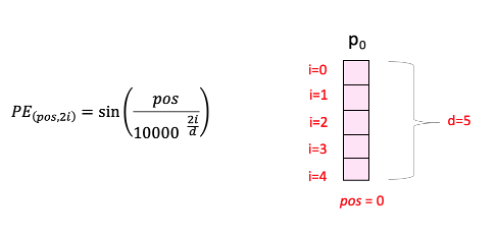


* pos = position of the word
* p_0 = positional embedding of first word
* d = size of word embedding
* i = each dimension of embedding

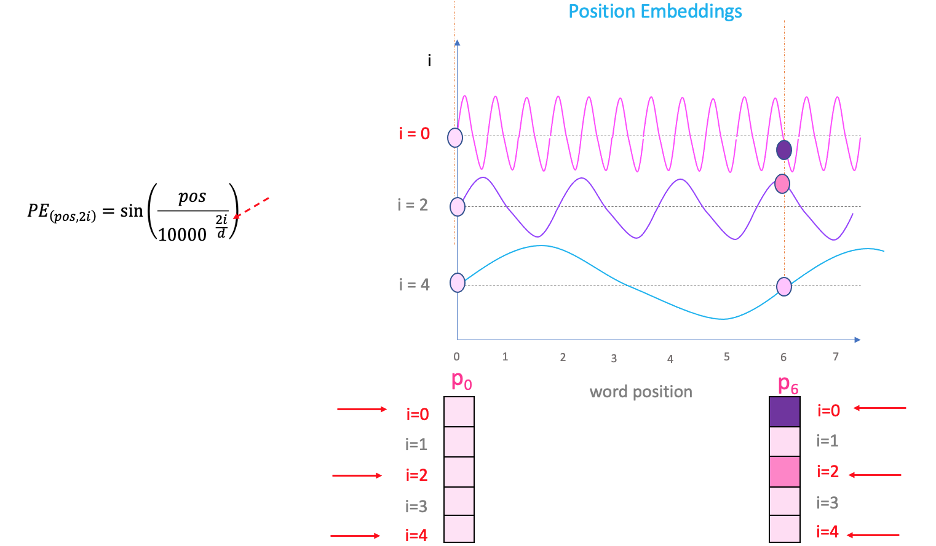


As we vary pos, we land up on different position values on y-axis. Thus words at different positions have different embeddings. However due to cyclic nature of sin or cos it may be possible that 2 position encodings map to same value in y-axis. Thus even i, is varied and we get curves with varying frequencies and thus each position embedding would be unique.

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)